# Entropy Analysis

In [1]:
import pandas as pd
import os
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx


os.chdir("/home/gabri/Desktop/ADA/ada-2024-project-theadacuates")
print(os.getcwd())


SAVE_FOLDER = "data/output/entropy_data"

/home/gabri/Desktop/ADA/ada-2024-project-theadacuates


## 1. **Transition Matrix Overview**

In order to calculate Entropy, we need the Transition Matrix.

The **transition matrix** is a representation of how frequently users move from one article to another in a navigation path. The matrix shows transitions between articles and the probability of each transition.

### Transition Matrix Types:
- **With Both Finished and Unfinished Paths:** Includes all transitions, whether the user completed the journey or not.
- **With Finished Paths:** Only includes transitions where the user reached a final goal or destination. --> not used

**transition matrix** is calculated in the next session, together with the entropy.

## 2. **Shannon Entropy for a Single Article**
**Shannon Entropy** measures the unpredictability or randomness in user transitions from one article to others. If an article leads to many different next articles with roughly equal probabilities, the entropy will be high.

The formula for Shannon Entropy \( H(X) \) is given by:

$$
H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)
$$

Where:
- **H(X)** is the Shannon entropy of the random variable **X**.
- **p(x_i)** is the probability of occurrence of each possible outcome **x_i** (e.g., the probability of transitioning to a specific next article).
- **n** is the total number of possible outcomes (next articles).



  
### High Entropy:
- **Indicates:** Users are transitioning from this article to many different articles without a clear dominant choice.
- **Possible Reasons:**
  - **Cognitive Load:** Users might be uncertain about which link to click next or are exploring multiple options.
  - **Unclear Navigation:** High-entropy areas may correspond to poor navigation design or overwhelming choices, leading to user confusion or cognitive overload.

### Implications of High Entropy:
- **Cognitive Overload:** Users may experience mental fatigue due to unclear paths.
- **Exploration vs. Confusion:** It may be an indicator of either natural exploration or poor design, depending on the context.


In [2]:
def calculate_entropy(transition_matrix):
    # Initialize entropy
    entropy = {}

    # Calculate entropy for each source article
    for source in transition_matrix.index:
        # Get the probabilities for transitions from this source
        probabilities = transition_matrix.loc[source]

        # Calculate entropy, treating zero probabilities as contributing zero
        entropy_value = 0
        for p in probabilities:
            if p > 0:  # Only calculate for non-zero probabilities
                entropy_value -= p * np.log2(p)  # Use log2 for bits

        # Store the entropy value for the source article
        entropy[source] = entropy_value

    return entropy


### Create a list of all edges played in the game

In [3]:
#need to make a played links list 
df_all = pd.read_csv('data/output/processed_data/paths_processed.csv', low_memory=False)

## this is an easy way to convert the object in resolve_path_list_name to an array of strings :D
links_list =[]
for path in df_all['resolved_path_list_name'].apply(ast.literal_eval):
  for n in range(len(path)-1):
    source = path[n]
    target = path[n+1]
    links_list.append((source, target))

all_played_links_df = pd.DataFrame(links_list, columns=['source', 'target'])

display(all_played_links_df.head(2))
print(all_played_links_df.shape)

# add id encoding of artcile id
df_articles = pd.read_csv("data/output/processed_data/articles_processed.csv")
display(df_articles.head(2))


all_played_links_df = all_played_links_df.merge(df_articles, how='left', left_on='source', right_on='article_name')
all_played_links_df.drop(columns=["article_name_encoded", "article_name"], inplace=True)
all_played_links_df.rename(columns={"article_id": "link_source_id"}, inplace=True)

all_played_links_df = all_played_links_df.merge(df_articles, how='left', left_on='target', right_on='article_name')
all_played_links_df.drop(columns=["article_name_encoded", "article_name"], inplace=True)
all_played_links_df.rename(columns={"article_id": "link_target_id"}, inplace=True)

display(all_played_links_df.head(2))
print(all_played_links_df.shape)

all_played_links_df.to_csv(os.path.join(SAVE_FOLDER, "all_played_links_simple.csv"), index = False)


,source,target
0,14th century,15th century
1,15th century,16th century


(398945, 2)


,article_name,article_name_encoded,article_id
0,Áedán mac Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
1,Åland,%C3%85land,1


,source,target,link_source_id,link_target_id
0,14th century,15th century,10,12
1,15th century,16th century,12,15


(398945, 4)


In [4]:
# Check if the transition matrix already exists

print("Creating transition Matrix (taking into account back-steps)...")

# Read df with all the steps (both in finished and unfinished paths)
df_links = pd.read_csv("data/output/entropy_data/all_played_links_simple.csv")
df_articles = pd.read_csv("data/output/processed_data/articles_processed.csv")

# Create an empty transition matrix
article_names = df_articles["article_id"]
empty_matrix = pd.DataFrame(0, index=article_names, columns=article_names)

# Count occurrences of transitions
for i, row in df_links.iterrows():
    source = row["link_source_id"]
    target = row["link_target_id"]
    empty_matrix.loc[source, target] += 1

# Step 3: Normalize to get probabilities
row_sums = empty_matrix.sum(axis=1)
row_sums[row_sums == 0] = 1  # Avoid division by zero
transition_matrix = empty_matrix.div(row_sums, axis=0)

# Display the transition matrix
#print("Transition Matrix:")
#print(transition_matrix)

# Save to CSV if needed
print("Saving Transition matrix...")
transition_matrix.to_csv("data/output/entropy_data/transition_matrix.csv")
print("Saved matrix.")


Creating transition Matrix (taking into account back-steps)...
Saving Transition matrix...
Saved matrix.


In [5]:
# Load transition Matrix
transition_matrix = pd.read_csv("data/output/entropy_data/transition_matrix.csv", index_col=0)
transition_matrix = transition_matrix.astype(float)  # Ensure the data type is float

# Caluclate Entropy
entropy_dict = calculate_entropy(transition_matrix)
entropy_df = pd.DataFrame(list(entropy_dict.items()), columns=['article_id', 'entropy'])
entropy_df["article_name"] = df_articles["article_name"]
print("Entropy Values:")
display(entropy_df)

entropy_df.to_csv("data/output/entropy_data/entropy_per_article.csv")


Entropy Values:


,article_id,entropy,article_name
0,0,0.000000,Áedán mac Gabráin
1,1,1.584963,Åland
2,2,2.584963,Édouard Manet
3,3,1.351644,Éire
4,4,0.000000,Óengus I of the Picts
...,...,...,...
4599,4599,3.836592,Zionism
4600,4600,2.950212,Zirconium
4601,4601,3.572469,Zoroaster
4602,4602,0.000000,Zuid-Gelders


In [6]:
#checj for nan
missing_rows = transition_matrix[transition_matrix.isnull().any(axis=1)]
print(missing_rows.shape)
missing_rows

missing_rows = entropy_df[entropy_df.isnull().any(axis=1)]
print(missing_rows.shape)
missing_rows

(0, 4604)
(0, 3)


,article_id,entropy,article_name


## 3. **Path-Based Entropy Analysis**

### Average Entropy of a Path:
- For each path, we calculate the **entropy of the source article** and accumulate it for the entire path. This gives a sense of how predictable or unpredictable the navigation experience is for that user journey.

In [ ]:
df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv", low_memory=False)
#display(df_paths)

#dict that map each srticle to the relative entripy
mapping_dict_entropy = pd.Series(entropy_df.entropy.values, index=entropy_df.article_id).to_dict()

#print(mapping_dict_entropy)

mean_entropies_path = []
for i, row in df_paths.iterrows():
    resolved_path_list_id = ast.literal_eval(row["resolved_path_list_id"])
    #print(resolved_path_list_id)
    if row["finished"] == True:
        # remove last elements (there is NO uncertaly after, the game is finsihed)
        resolved_path_list_id = resolved_path_list_id[:-1]
    #print(resolved_path_list_id)
    path_entropies = [mapping_dict_entropy[item] for item in resolved_path_list_id]  
    #print(path_entropies)
    mean_entropy = np.mean(path_entropies)
    if mean_entropy == None:
        print(i) 
    mean_entropies_path.append(mean_entropy)
    #print(f"{i}/{df_paths.shape[0]} --> {100*i/df_paths.shape[0]:.2f}%")


df_paths["entropy_path"] = mean_entropies_path

display(df_paths.head(3))

# Save
df_paths.to_csv(os.path.join(SAVE_FOLDER, "paths_cognitive_shift.csv"), index = False)


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name,entropy_path
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century...",4.720552
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic...",5.046673
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"['14th century', 'Niger', 'Nigeria', 'British ...",14th century,African slave trade,True,NaN,8,0,2012-10-03 23:10:40,0.057971,17.250000,0.0,"[10, 2982, 2984, 694, 3755, 128, 379, 143]","[10, 2982, 2984, 694, 3755, 128, 379, 143]","['14th century', 'Niger', 'Nigeria', 'British ...",4.758226


## 4. **Plots**
- **Transition Matrix Graphs:** Visualize the transition probabilities between articles to easily spot high-frequency paths and anomalies.

### Transition matrix Graph

In [8]:
#Create adj matrix
size = transition_matrix.shape[0]#number nodes
print(f"Number of nodes {transition_matrix.shape}")
matrix = transition_matrix.values
#adj = pd.DataFrame(matrix, index=range(size), columns=range(size))
adj = pd.DataFrame(matrix, index=df_articles["article_name"], columns=df_articles["article_name"])
adj.to_csv(os.path.join(SAVE_FOLDER, "entropy_adj.csv"))
adj

Number of nodes (4604, 4604)


article_name,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins,10th century,11th century,12th century,13th century,...,Ziad Jarrah,Zimbabwe,Zinc,Zinc chloride,Zion National Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
article_name,,,,,,,,,,,,,,,,,,,,,
Áedán mac Gabráin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Åland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Édouard Manet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Éire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Óengus I of the Picts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zirconium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zoroaster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


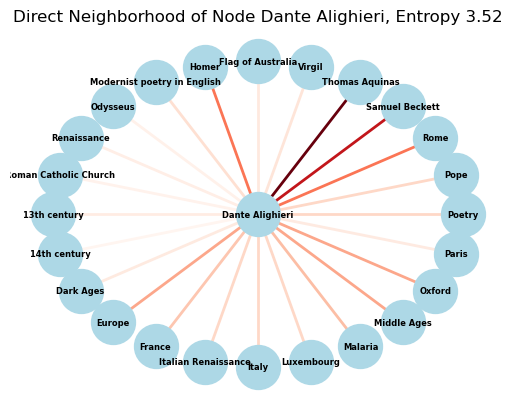

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Select the specific node for which you want to draw its neighborhood
node_of_interest = "Dante Alighieri"  # Replace with the actual node label

# Create the graph from the adjacency matrix
G = nx.from_pandas_adjacency(adj)

# Get only the edges directly connected to the node_of_interest
ego_edges = [(node_of_interest, neighbor) for neighbor in G.neighbors(node_of_interest)]
ego_subgraph = G.edge_subgraph(ego_edges)  # Create a subgraph with only those edges

# Define positions for the nodes in a star layout (circular around the core)
pos = nx.shell_layout(ego_subgraph, nlist=[[node_of_interest], list(G.neighbors(node_of_interest))])

# Get edge weights and map them to colors on a heatmap
edge_weights = np.array([G.edges[edge]['weight'] for edge in ego_edges])
norm = plt.Normalize(vmin=edge_weights.min(), vmax=edge_weights.max())  # Normalize weights for color mapping
edge_colors = [cm.Reds(norm(weight)) for weight in edge_weights]  # Map weights to colors using colormap

# Draw the subgraph with scaled edge colors based on weights
fig, ax = plt.subplots()
fig.patch.set_facecolor('black')  # Set the background color of the entire figure to black
ax.set_facecolor('black')  # Set the plot area background to black

nx.draw(
    ego_subgraph,
    pos,
    with_labels=True,
    node_size=1000,
    node_color='lightblue',
    font_size=6,
    font_weight='bold',
    edge_color=edge_colors,  # Use color map for edge colors
    width=2,  # Set a fixed width for better visibility
    ax=ax     # Draw on the specified axis
)

# Set the title with white font color for visibility on black background
plt.title(f'Direct Neighborhood of Node {node_of_interest}, Entropy {entropy_df[entropy_df["article_name"] == node_of_interest]["entropy"].values[0]:.2f}', color='black')
plt.show()


# Correaltion between finished/Unfinished and Entropy

In [10]:
from scipy.stats import pointbiserialr

# Assuming `category` is binary (0/1) and `continuous_var` is the continuous variable
correlation, p_value = pointbiserialr(df_paths["finished"], df_paths["entropy_path"])
print(f"Point-Biserial Correlation: {correlation}, p-value: {p_value}")


Point-Biserial Correlation: 0.19409625942219272, p-value: 0.0


### Plot Distributions

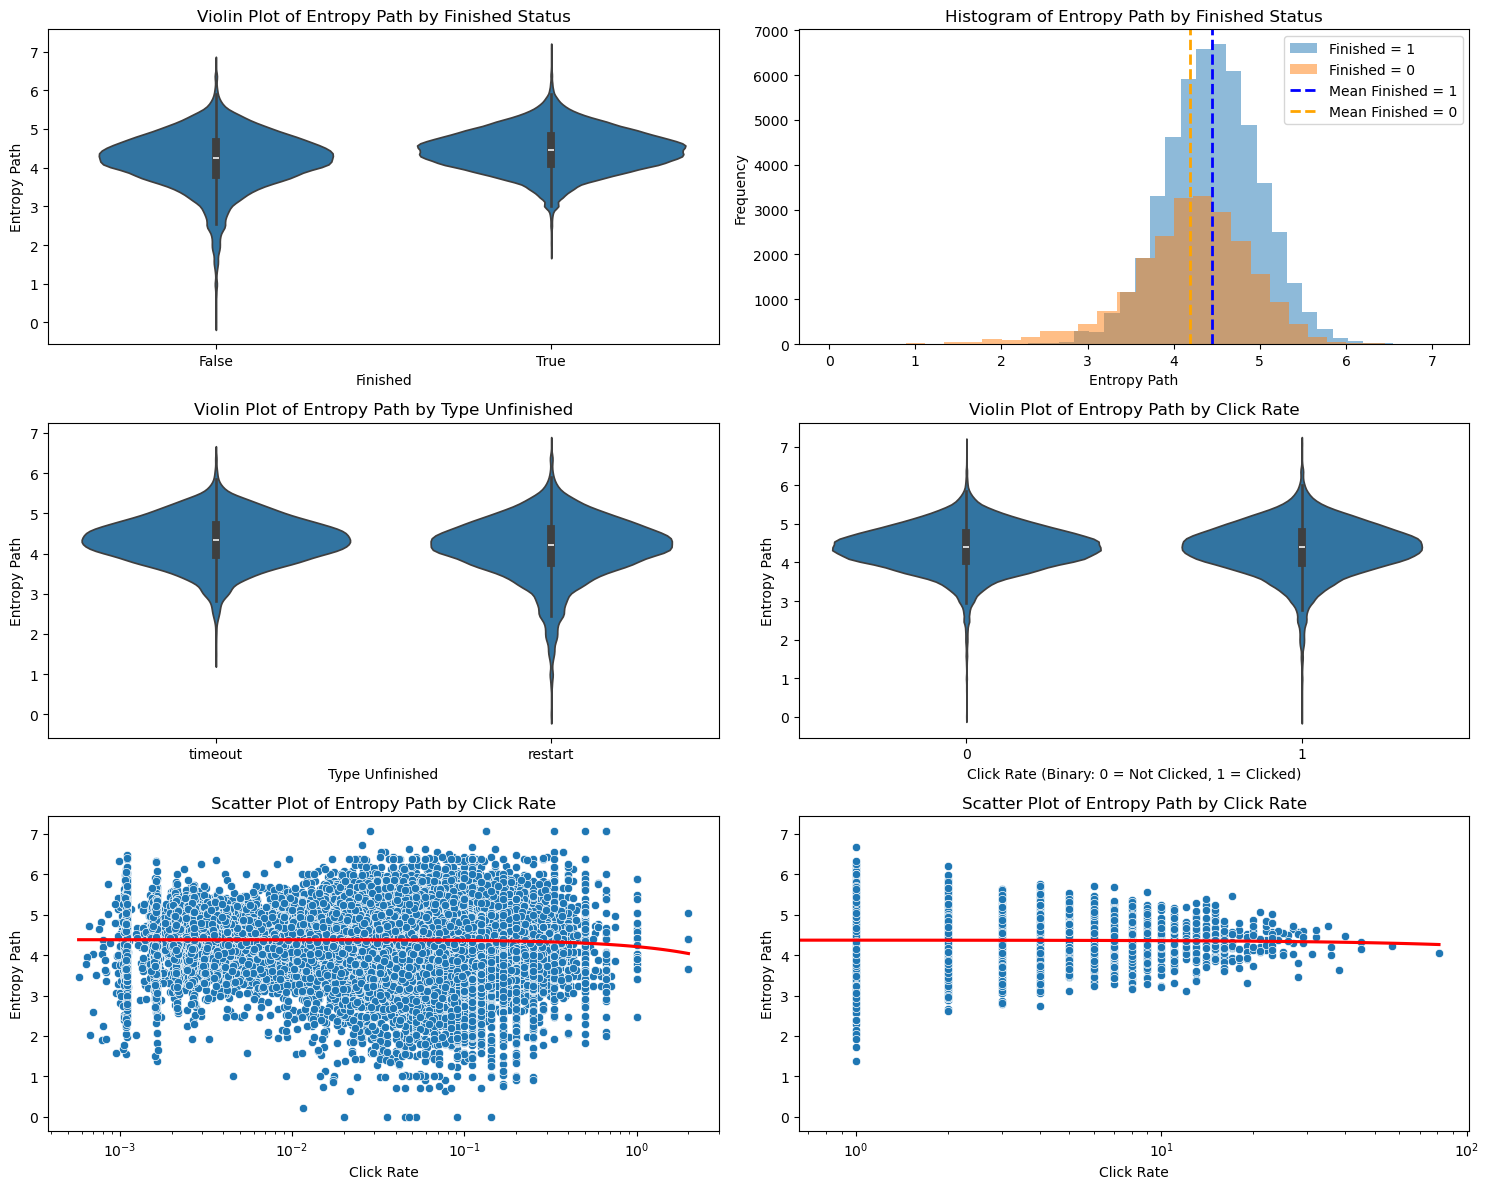

In [11]:
# Create a single figure with multiple subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns


# Violin plot: Entropy Path Distribution by Finished Status
sns.violinplot(ax=axs[0, 0], x='finished', y='entropy_path', data=df_paths)
axs[0, 0].set_title('Violin Plot of Entropy Path by Finished Status')
axs[0, 0].set_xlabel('Finished')
axs[0, 0].set_ylabel('Entropy Path')

# Histogram of Entropy Path by Finished Status
mean_finished_1 = df_paths[df_paths['finished'] == 1]['entropy_path'].mean()
mean_finished_0 = df_paths[df_paths['finished'] == 0]['entropy_path'].mean()
axs[0, 1].hist(df_paths[df_paths['finished'] == 1]['entropy_path'].dropna(), bins=30, alpha=0.5, label='Finished = 1')
axs[0, 1].hist(df_paths[df_paths['finished'] == 0]['entropy_path'].dropna(), bins=30, alpha=0.5, label='Finished = 0')
axs[0, 1].axvline(mean_finished_1, color='blue', linestyle='dashed', linewidth=2, label='Mean Finished = 1')
axs[0, 1].axvline(mean_finished_0, color='orange', linestyle='dashed', linewidth=2, label='Mean Finished = 0')
axs[0, 1].set_title('Histogram of Entropy Path by Finished Status')
axs[0, 1].set_xlabel('Entropy Path')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Violin plot: Entropy Path Distribution by Type of Unfinished Paths
sns.violinplot(ax=axs[1, 0], x='type_unfinished', y='entropy_path', data=df_paths[df_paths["finished"] == False])
axs[1, 0].set_title('Violin Plot of Entropy Path by Type Unfinished')
axs[1, 0].set_xlabel('Type Unfinished')
axs[1, 0].set_ylabel('Entropy Path')

# Histogram of Entropy Path by Type of Unfinished Paths
# group_restart = df_paths[(df_paths['finished'] == False) & (df_paths['type_unfinished'] == 'restart')]
# group_timeout = df_paths[(df_paths['finished'] == False) & (df_paths['type_unfinished'] == 'timeout')]
# mean_entropy_restart = group_restart['entropy_path'].mean()  # Mean for 'restart'
# mean_entropy_timeout = group_timeout['entropy_path'].mean()  # Mean for 'timeout'
# axs[1, 1].hist(group_restart['entropy_path'].dropna(), bins=30, alpha=0.5, label='Type Restart')
# axs[1, 1].hist(group_timeout['entropy_path'].dropna(), bins=30, alpha=0.5, label='Type Timeout')
# axs[1, 1].axvline(mean_entropy_restart, color='blue', linestyle='dashed', linewidth=2, label=f'Mean Restart = {mean_entropy_restart:.2f}')  # Add mean line for 'restart'
# axs[1, 1].axvline(mean_entropy_timeout, color='orange', linestyle='dashed', linewidth=2, label=f'Mean Timeout = {mean_entropy_timeout:.2f}')  # Add mean line for 'timeout'
# axs[1, 1].set_title('Histogram of Entropy Path by Type Unfinished')
# axs[1, 1].set_xlabel('Entropy Path')
# axs[1, 1].set_ylabel('Frequency')
# axs[1, 1].legend()

# Violin plot: Entropy Path by Click Rate (Binary)
threshold = df_paths['click_rate'].mean()
df_paths['click_rate_binary'] = (df_paths['click_rate'] > threshold).astype(int)
sns.violinplot(ax=axs[1, 1], x='click_rate_binary', y='entropy_path', data=df_paths)
axs[1, 1].set_title('Violin Plot of Entropy Path by Click Rate')
axs[1, 1].set_xlabel('Click Rate (Binary: 0 = Not Clicked, 1 = Clicked)')
axs[1, 1].set_ylabel('Entropy Path')

# MISSING WITH HIST

# Scatter plot: Entropy Path vs Click Rate
sns.scatterplot(ax=axs[2, 0], x='click_rate', y='entropy_path', data=df_paths)
sns.regplot(ax=axs[2, 0], x='click_rate', y='entropy_path', data=df_paths, scatter=False, color='red', ci=None)  # Linear regression line
axs[2, 0].set_title('Scatter Plot of Entropy Path by Click Rate')
axs[2, 0].set_xlabel('Click Rate')
axs[2, 0].set_ylabel('Entropy Path')
axs[2, 0].set_xscale("log")

# Scatter plot: Entropy Path vs Click Rate
sns.scatterplot(ax=axs[2, 1], x='n_back', y='entropy_path', data=df_paths)
sns.regplot(ax=axs[2, 1], x='n_back', y='entropy_path', data=df_paths, scatter=False, color='red', ci=None)  # Linear regression line
axs[2, 1].set_title('Scatter Plot of Entropy Path by Click Rate')
axs[2, 1].set_xlabel('Click Rate')
axs[2, 1].set_ylabel('Entropy Path')
axs[2, 1].set_xscale("log")

# Adjust layout and show grid
plt.tight_layout()
plt.show()

# Statistical Analysis

In [12]:

# Separate the groups based on the 'finished' column
group1 = df_paths[df_paths['finished'] == 1]['entropy_path'].dropna()  # Group where finished = 1
group2 = df_paths[df_paths['finished'] == 0]['entropy_path'].dropna()  # Group where finished = 0

# Perform an independent t-test
# ATTENTION: from the hist of above the data seems gaussian
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)  # Use equal_var=False for Welch's t-test

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: The means are not significantly different.")


T-statistic: 53.86419551049631
P-value: 0.0
Reject the null hypothesis: The means are significantly different.


Ah, wow, this seems unexpected! The average entropy between finished and unfinished paths is statistically different, but the relationship is surprising. Since entropy is a metric of uncertainty, we expected that in unfinished paths, the metric would be higher. This is because users could feel lost or may not have a precise idea of where to navigate, thus leading to greater entropy. However, the results reveal the opposite: on average, finished paths show higher entropy. Let's investigate this strange behavior further.



# Explain Entropy with Connectivity

In [13]:
# Correlation between articles that have high entropy are the sma ewiht high connectivity
entropy_df




,article_id,entropy,article_name
0,0,0.000000,Áedán mac Gabráin
1,1,1.584963,Åland
2,2,2.584963,Édouard Manet
3,3,1.351644,Éire
4,4,0.000000,Óengus I of the Picts
...,...,...,...
4599,4599,3.836592,Zionism
4600,4600,2.950212,Zirconium
4601,4601,3.572469,Zoroaster
4602,4602,0.000000,Zuid-Gelders


In [14]:
# Remember the fact tha in finshed path the strategy is "going before to highe connecitivyt nodes" 





# 5. Conclusion
Yes, there is a difference between finished and unfinished paths in relation to entropy, but not as expected. Finished paths have higher entropy, which completely contradicts the Peppito hypothesis that cognitive load and uncertainty can play a role in the game. We have shown that this behavior is primarily due to the main strategy in the game, which involves moving toward highly connected nodes. These nodes inherently have high entropy, not because of human uncertainty, but simply because they possess more connections, allowing transition probabilities to spread out more easily.

We have also demonstrated that there are no differences in entropy between the different types of unfinished paths (temporary or abandoned) and that no relationship exists between the clicking rate (a proxy for uncertainty, as higher click rates indicate more decisions on the next page) and the number of back clicks.

In summary, entropy is not a good proxy for cognitive load, as it represents a metric more correlated with connectivity rather than a true neurological load associated with gameplay.
